In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1641043062000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 * 24

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low      Volume
0     2022-01-01 22:59:59  3710.04  3697.61  3713.68  3691.88   5365.4474
1     2022-01-01 23:59:59  3697.04  3725.30  3745.36  3693.22   9380.2088
2     2022-01-02 00:59:59  3725.29  3727.62  3749.98  3718.71   6785.1471
3     2022-01-02 01:59:59  3727.61  3760.77  3764.98  3727.24   8926.8519
4     2022-01-02 02:59:59  3760.76  3752.58  3766.00  3740.00   6665.3581
...                   ...      ...      ...      ...      ...         ...
3995  2023-03-18 13:59:59  1805.57  1813.17  1815.43  1801.53  16643.0365
3996  2023-03-18 14:59:59  1813.18  1812.36  1813.56  1807.79  11521.3586
3997  2023-03-18 15:59:59  1812.36  1814.12  1821.40  1809.41  19670.8672
3998  2023-03-18 16:59:59  1814.12  1809.27  1816.42  1790.92  35670.7570
3999  2023-03-18 17:59:59  1809.26  1812.24  1813.85  1801.56  15856.9394

[4000 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slow_k'] < df['slow_d']
    return series.diff() & series

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low      Volume  \
0     2022-01-01 22:59:59  3710.04  3697.61  3713.68  3691.88   5365.4474   
1     2022-01-01 23:59:59  3697.04  3725.30  3745.36  3693.22   9380.2088   
2     2022-01-02 00:59:59  3725.29  3727.62  3749.98  3718.71   6785.1471   
3     2022-01-02 01:59:59  3727.61  3760.77  3764.98  3727.24   8926.8519   
4     2022-01-02 02:59:59  3760.76  3752.58  3766.00  3740.00   6665.3581   
...                   ...      ...      ...      ...      ...         ...   
3995  2023-03-18 13:59:59  1805.57  1813.17  1815.43  1801.53  16643.0365   
3996  2023-03-18 14:59:59  1813.18  1812.36  1813.56  1807.79  11521.3586   
3997  2023-03-18 15:59:59  1812.36  1814.12  1821.40  1809.41  19670.8672   
3998  2023-03-18 16:59:59  1814.12  1809.27  1816.42  1790.92  35670.7570   
3999  2023-03-18 17:59:59  1809.26  1812.24  1813.85  1801.56  15856.9394   

            ema_8       ema_14       ema_50        atr     slow_k     slow_

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] <= df['ema_50']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_short'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_short'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_14,ema_50,atr,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_short
0,2022-01-01 22:59:59,3710.04,3697.61,3713.68,3691.88,5365.4474,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
1,2022-01-01 23:59:59,3697.04,3725.30,3745.36,3693.22,9380.2088,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
2,2022-01-02 00:59:59,3725.29,3727.62,3749.98,3718.71,6785.1471,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
3,2022-01-02 01:59:59,3727.61,3760.77,3764.98,3727.24,8926.8519,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
4,2022-01-02 02:59:59,3760.76,3752.58,3766.00,3740.00,6665.3581,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2023-03-18 13:59:59,1805.57,1813.17,1815.43,1801.53,16643.0365,1798.387012,1782.051926,1727.500392,21.807916,85.025548,82.701993,False,False,False,False,False,False,False
3996,2023-03-18 14:59:59,1813.18,1812.36,1813.56,1807.79,11521.3586,1801.492120,1786.093003,1730.828220,20.662351,84.073173,82.788416,False,False,False,False,False,False,False
3997,2023-03-18 15:59:59,1812.36,1814.12,1821.40,1809.41,19670.8672,1804.298316,1789.829936,1734.094565,20.042897,85.354652,84.817791,False,False,False,False,False,False,False
3998,2023-03-18 16:59:59,1814.12,1809.27,1816.42,1790.92,35670.7570,1805.403134,1792.421944,1737.042621,20.432690,78.449370,82.625732,True,True,False,False,False,False,False


In [11]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_short'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + 3 * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        entry_df.at[index, 'status'] = 'Pending'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
    
for index, row in entry_df.iterrows():
    # Check if the jth row's status is 'Pending'
    if entry_df.loc[index, 'status'] == 'Pending':
        for j in range(index, len(entry_df)):
            if entry_df.loc[j, 'Low'] <= entry_df.loc[index, 'take_profit']:
                profit = -(entry_df.loc[index, 'take_profit'] - entry_df.loc[index, 'entry_p'])
                entry_df.loc[index, 'status'] = 'Close_Short'
                entry_df.loc[index, 'profit'] = profit
                break

            if entry_df.loc[j, 'Close'] >= entry_df.loc[index, 'stop_loss']:
                profit = -(entry_df.loc[index, 'stop_loss'] - entry_df.loc[index, 'entry_p'])
                entry_df.loc[index, 'status'] = 'Stop'
                entry_df.loc[index, 'profit'] = profit
                break
        
for index, row in entry_df.iterrows():

    if entry_df.loc[index, 'status'] == 'Pending':
        entry_df.loc[index, 'profit'] = 0

entry_df.to_csv('entry_df.csv')

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_short'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Close_Short') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


               Close_Time     Open    Close     High      Low      Volume  \
58    2022-01-04 08:59:59  3765.89  3743.11  3774.36  3736.94   8719.5215   
59    2022-01-04 09:59:59  3743.11  3732.26  3760.03  3728.10   7623.7429   
107   2022-01-06 09:59:59  3538.85  3525.13  3540.00  3501.83  15755.2747   
108   2022-01-06 10:59:59  3525.13  3508.31  3529.71  3491.47  19040.2744   
112   2022-01-06 14:59:59  3456.97  3438.73  3468.10  3419.94  18913.5143   
...                   ...      ...      ...      ...      ...         ...   
3838  2023-03-12 00:59:59  1428.00  1431.93  1433.38  1422.32  41538.7231   
3938  2023-03-16 04:59:59  1648.00  1647.04  1653.17  1637.72  23227.7264   
3939  2023-03-16 05:59:59  1647.04  1653.80  1654.40  1646.00  14007.0757   
3942  2023-03-16 08:59:59  1649.95  1640.18  1659.71  1638.90  32158.7723   
3943  2023-03-16 09:59:59  1640.18  1645.61  1648.51  1632.18  25777.9814   

            ema_8       ema_14       ema_50        atr  ...    c3    c4  \


In [12]:
# 部位回測

posdf = entry_df.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Short')]


col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'position', 'entry_p', 'stop_loss', 'take_profit', 'status', 'profit']
pos = posdf[col]
pos = pos.reset_index(drop = True)

        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.03 / 100
entry_amt = pos.entry_p.sum()
SL_amt = pos.loc[pos.status == 'Stop', 'stop_loss'].sum()
TP_amt = pos.loc[pos.status == 'Close_Short', 'take_profit'].sum()
ttl_fee = (entry_amt + SL_amt + TP_amt) * fee

# 損益
leverage = 10
ttl_profit = pos.profit.sum() - ttl_fee

wins = pos['status'].str.count('Close_Short').sum()
loses = pos['status'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low        atr  \
0    2022-01-04 09:59:59  3743.11  3732.26  3760.03  3728.10  33.317402   
1    2022-01-06 10:59:59  3525.13  3508.31  3529.71  3491.47  49.814495   
2    2022-01-06 15:59:59  3438.74  3453.12  3463.39  3426.31  50.079410   
3    2022-01-06 17:59:59  3405.56  3308.44  3408.37  3300.00  55.700256   
4    2022-01-07 08:59:59  3406.81  3366.71  3416.76  3365.01  43.088241   
..                   ...      ...      ...      ...      ...        ...   
263  2023-03-10 23:59:59  1401.24  1417.03  1420.39  1397.02  20.644573   
264  2023-03-11 02:59:59  1407.42  1403.85  1415.25  1401.97  20.577732   
265  2023-03-12 00:59:59  1428.00  1431.93  1433.38  1422.32  17.211800   
266  2023-03-16 05:59:59  1647.04  1653.80  1654.40  1646.00  23.049353   
267  2023-03-16 09:59:59  1640.18  1645.61  1648.51  1632.18  21.672422   

    position  entry_p    stop_loss  take_profit       status      profit  
0      Short  3743.11  3

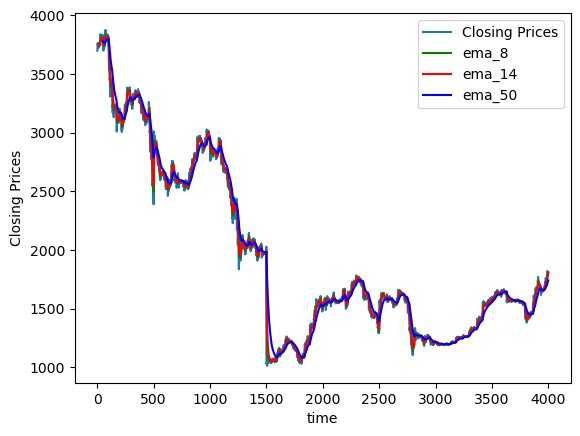

In [13]:
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')

plt.plot(df.ema_8, label='ema_8', c='g')
plt.plot(df.ema_14, label='ema_14', c='r')
plt.plot(df.ema_50, label='ema_50', c='b')
plt.legend()
plt.show()